In [2]:
from huggingface_hub import InferenceClient
import numpy as np

x = np.random.randint(0, 1e7)

client = InferenceClient(model="mistralai/Mistral-7B-Instruct-v0.2")
prompt = "[INST] Please write a poem about the weather [/INST]"
output = client.text_generation(prompt, max_new_tokens=500, do_sample=True, temperature=1.0, seed=x)
print(output)

 In the delicate dance of sky and earth,

The weather paints a canvas vast and wide,
With strokes of brush both gentle and mirth,
A symphony of vision to delight.

Now stirs the wind, a playful, whispering tongue,
To brush the grasses, to make leaves sigh,
Through orchards rich with ripe and bursting fruit,
And over went the sunlit autumn sky.

The sun bows low, a golden orbéd sloop,
Beneath a sea of rose and cerulean hue,
As gentle, falling snowflakes leap and leap,
A hushed and festive snowdance new.

Drizzling lingers, quiet tears upon the ground,
Reflections history in mirrored pond,
Its whispers tell the tales of winds long past,
And secret hearts within the tides are found.

A storm awakes, the thunder brethren bellow,
A symphony of drums and trumpet scream,
Then lightning, mid-air serpents snake and slither,
Against the fiery, churning cataract of rain we dream.

At last calm nears, the storm retreats and dwindles,
Leaving in its wake a stillness deep,
Heart of the earth rests, 

In [12]:
from huggingface_hub import InferenceClient
import numpy as np

x = np.random.randint(0, 1e7)

client = InferenceClient(model="WhereIsAI/UAE-Large-V1")
prompt = "Please write a poem about the weather"
output = client.feature_extraction(prompt)


In [13]:

def get_feature_vec(prompt):
    output = client.feature_extraction(prompt)
    return output[0][-1] / np.linalg.norm(output[0][-1])

(1, 9, 1024)


<Axes: >

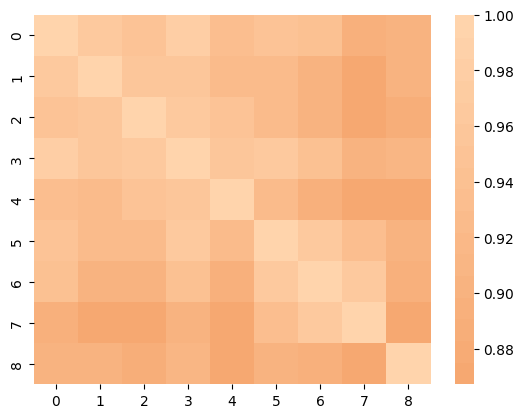

In [5]:
print(output.shape)
norms = np.linalg.norm(output[0], axis=1)
v = output[0]
for i, vec in enumerate(v):
    v[i] = vec / norms[i]

dots = (v @ v.T)

import seaborn as sns
sns.heatmap(dots, center = 0)

In [9]:
import json

with open("/Users/mac/Downloads/labelled_examples_mistral4_modified.json") as f:
    dataset = json.load(f)

In [14]:
from tqdm import tqdm

for text_obj in tqdm(dataset[62:]):
    for split_text in text_obj["split_text"]:
        prompt = split_text["text"]
        vec = get_feature_vec(prompt)
        split_text["vec"] = vec

100%|██████████| 388/388 [1:43:02<00:00, 15.93s/it]


In [15]:
from collections import defaultdict

genre_vecs = defaultdict(list)

for text_obj in tqdm(dataset):
    for split_text in text_obj["split_text"]:
        genre = split_text["genre"]
        vec = split_text["vec"]
        genre_vecs[genre].append(vec)

100%|██████████| 450/450 [00:00<00:00, 63820.82it/s]


In [16]:
all_vecs = []
for vec_list in genre_vecs.values():
    all_vecs.extend(vec_list)


In [17]:
np.array(all_vecs)

array([[ 0.03104038,  0.04277351, -0.00401825, ..., -0.04824588,
        -0.04549193, -0.01716249],
       [ 0.03106613, -0.00692389, -0.04780738, ...,  0.01592547,
        -0.01821462, -0.03664605],
       [ 0.02141074, -0.01771009, -0.01220475, ..., -0.021662  ,
        -0.02184805, -0.03184609],
       ...,
       [ 0.0081925 ,  0.04474366,  0.00756334, ..., -0.00228074,
        -0.01350697, -0.02633345],
       [ 0.02435106, -0.00181165,  0.02805429, ..., -0.01604701,
        -0.028667  ,  0.00555544],
       [-0.02840008,  0.05217835,  0.0182831 , ..., -0.00092542,
        -0.0123725 , -0.01524873]], dtype=float32)

In [18]:
import matplotlib.pyplot as plt
import phate

# Step 1: Combine all vectors into a single dataset and create a labels list
data = []
labels = []
for genre, vecs in genre_vecs.items():
    data.extend(vecs)
    labels.extend([genre] * len(vecs))

data = np.array(data)  # Convert list of vectors into a numpy array for PHATE

# Step 2: Assign unique colors to each genre
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Step 3: Initialize and fit-transform with PHATE
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data)

# Step 4: Plotting the PHATE result with genres in different colors
for label in unique_labels:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(data_phate[idx, 0], data_phate[idx, 1], c=[color_map[label]], label=label, alpha=0.6)

plt.title('PHATE Embedding of Genre Vectors')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')
plt.colorbar(label='Point index')
plt.legend()
plt.show()


ImportError: dlopen(/Users/mac/Documents/taker/.venv/lib/python3.11/site-packages/_layout.cpython-311-darwin.so, 0x0002): tried: '/Users/mac/Documents/taker/.venv/lib/python3.11/site-packages/_layout.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/mac/Documents/taker/.venv/lib/python3.11/site-packages/_layout.cpython-311-darwin.so' (no such file), '/Users/mac/Documents/taker/.venv/lib/python3.11/site-packages/_layout.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

In [19]:
np.save("mistral4-split-vecs.pickle", dataset, allow_pickle=True)
#np.save("mistral4-split-vecs.pickle", dataset, allow_pickle=True)


In [20]:
_dataset = np.load("mistral4-split-vecs.pickle.npy", allow_pickle=True)

print(_dataset)

[{'prompt': 'Make me a dialogue from a political debate program.', 'seed': 916564, 'orig_text': '\n\nTitle: "The Political Arena"\n\nHost (Jim): Welcome to "The Political Arena," where we bring you the latest news and debates on political issues. I\'m Jim DeSantis, your moderator. Today, we have two esteemed guests with us, Senator Johnston from the Democratic party, and Representative Thompson from the Republican party. Both of them are running for re-election in November, and they\'ve agreed to discuss some of the major issues of the upcoming campaign. Let\'s get started.\n\nFirst, let\'s talk about healthcare. According to recent polls, healthcare remains the top concern for most voters. Senator Johnston, what would you propose as a solution for the current healthcare system, and how would it be funded?\n\nSenator Johnston: Thank you, Jim. I believe that every American deserves access to affordable, quality healthcare, and that\'s exactly what I\'ve been fighting for in the Senate. 